#### Unicode Fractions

In this notebook we test the processing of [Unicode](https://home.unicode.org) characters by playing around with [glyphs used for displaying fractions](https://en.wikipedia.org/wiki/Number_Forms).

First we create a *SAS* session and redefine `dbDISPLAY` - for details see the `Classy Cars` notebook.

In [0]:
import saspy
# Start a SAS Session using config file
sas = saspy.SASsession(
  cfgfile = '/databricks/sasconfig/sascfg_personal.py',
  cfgname = 'ssh_sas',
  display = 'databricks')
# Redefine `sas.DISPLAY`
def dbDISPLAY(x):
  displayHTML(x)
sas.DISPLAY = dbDISPLAY

SAS Connection established. Subprocess id is 1174

Then we extract the required fraction glyphs by parsing - here we utilize `curl` and `awk` on the command line with the `%sh` directive - the javascript library [math.js](https://github.com/lights0123/fractions/blob/master/math.js) from the [Unicode Fraction Creator](https://lights0123.com/fractions/) site, store the information in CSV format...

In [0]:
%sh
curl https://raw.githubusercontent.com/lights0123/fractions/master/math.js | \
awk -F'\x27' -v OFS=';' ' # \x27 is single quote
 BEGIN { print "ASCII;UTF8;TYPE" }
 /superscript/ {T="P"}
 /subscript/   {T="B"}
 /fractions/   {T="F"}
 NF>4 {print $2, $4, T}
' > /dbfs/FileStore/tables/sas_dbr_demo/ms.csv

% Total % Received % Xferd Average Speed Time Time Time Current
 Dload Upload Total Spent Left Speed

 0 0 0 0 0 0 0 0 --:--:-- --:--:-- --:--:-- 0
100 3874 100 3874 0 0 32283 0 --:--:-- --:--:-- --:--:-- 32283

... and load it to the `ms` Pandas data frame. Note, that `TYPE='F'` contains the few fractions available as as a symbol. All other fractions have to be constructed from superscripts `TYPE='P'` and subscripts `TYPE='B'` together with the [FRACTION SLASH](https://util.unicode.org/UnicodeJsps/character.jsp?a=2044) character `⁄`.

In [0]:
import pandas as pd
ms = pd.read_csv("/dbfs/FileStore/tables/sas_dbr_demo/ms.csv", sep=';', encoding='utf-8')
display(ms)

ASCII,UTF8,TYPE
0,⁰,P
1,¹,P
2,²,P
3,³,P
4,⁴,P
5,⁵,P
6,⁶,P
7,⁷,P
8,⁸,P
9,⁹,P


Finally, create the Pandas data frame `uf` with all reduced fractions between 0 and 1 with denominator ≤12 ...

In [0]:
import math
D = 12
rs = [] # rational numbers 
fs = [] # fraction strings
ns = [] # numerators
ds = [] # denominators

def u8(ascii, type): # Receive UTF8 from `ms` given ASCII and TYPE  
  return ''.join( [ms.query(f"ASCII=='{c}' & TYPE=='{type}'").UTF8.iloc[0] for c in str(ascii)] )

for d in list(range(2,D+1)):
  for n in range(1,d):
    if math.gcd(d,n)==1:
      rs += [n/d]
      ds += [d]
      ns += [n]
      u = ms.query(f"ASCII=='{n}/{d}'")
      if not u.empty:
        fs += [u.UTF8.iloc[0]]
      else:
        fs += [f"{u8(n,'P')}⁄{u8(d,'B')}"] # NB. `⁄` is FRACTION SLASH

uf = pd.DataFrame({ 'r': rs, 'f': fs, 'n': ns, 'd': ds })
display(uf)


r,f,n,d
0.5,½,1,2
0.3333333333333333,⅓,1,3
0.6666666666666666,⅔,2,3
0.25,¼,1,4
0.75,¾,3,4
0.2,⅕,1,5
0.4,⅖,2,5
0.6,⅗,3,5
0.8,⅘,4,5
0.16666666666666666,⅙,1,6


... after transfering the data frame to *SAS* table `uf` we create a *SQL* query in *SAS*. Note, that we have to use [National Language Support (NLS) functions](https://documentation.sas.com/doc/en/pgmsascdc/9.4_3.5/nlsref/p18bboh5zrwqw5n1kkhonig4jpwq.htm) like `unicodelen` and `kindex` (column `xs` is the index of the FRACTION SLASH); `length` will mislead us here as it shows the byte length `bl` which for example is different for `½` and `⅓` depending on their *UTF-8* representation.

In [0]:
uf_sas = sas.df2sd( uf, 'uf' )
sas.submitLST("""
 title "Reduced fractions with denominator ≤12";
 proc sql; select *, length(f) AS bl, unicodelen(f) AS ul, kindex(f,'⁄') AS xs from uf; quit;
""")


r,f,n,d,bl,ul,xs
0.5,½,1,2,2,1,0
0.333333,⅓,1,3,3,1,0
0.666667,⅔,2,3,3,1,0
0.25,¼,1,4,2,1,0
0.75,¾,3,4,2,1,0
0.2,⅕,1,5,3,1,0
0.4,⅖,2,5,3,1,0
0.6,⅗,3,5,3,1,0
0.8,⅘,4,5,3,1,0
0.166667,⅙,1,6,3,1,0


Showing all our reduced fractions in a `PROC SGPLOT` bubble plot.
Only *SVG* output format renders all fractions correctly, if using any image format like *PNG* or *JPG* the 3 fractions `⅐`, `⅑` and `⅒` cannot be displayed. Reason might be, that they were not part of Unicode 1.0 - see [Searching in 𝕌𝕟𝕚𝕔𝕠𝕕𝕖 character names for VULGAR FRACTION](https://unicode-search.net/unicode-namesearch.pl?term=VULGAR%20FRACTION) - and *SAS* missed an update...

<!DOCTYPE html>
 
 
 
 
 SAS Output 

 
 
 
 
<!DOCTYPE html>
 
 
 
 
 SAS Output
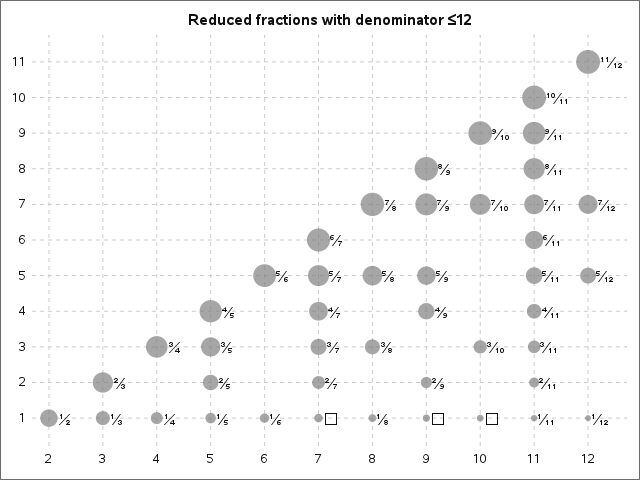

In [0]:
sas.submitLST('''
ods html5 (id=saspy_internal) file=stdout options(svg_mode='inline') device=svg style=Dove;
ods graphics on / outputfmt=png;
proc sgplot data=uf noborder;
  bubble x=d y=n size=r /
    fillattrs=(color=turqois transparency=.3) bradiusmin=3px bradiusmax=12px nooutline
    datalabel=f datalabelpos=right datalabelattrs=(family="Arial Unicode MS" size=12);
  xaxis values=(2 to 12 by 1) grid display=(noline noticks nolabel);
  yaxis values=(1 to 11 by 1) grid display=(noline noticks nolabel);
run;
''')
# Arial Unicode MS
# Times New Roman Uni